A first attempt at reverse engineering the geometry of CLIP embeddings on CIFAR10.

### Load libraries

In [1]:
import copy
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import umap
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import linear_probe
from src.utils import runs_to_df

### Load data

In [2]:
CIFAR_CLS_NAMES = (
    "plane",
    "car",  # "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [3]:
def get_cifar_ds(normalize: bool = True) -> linear_probe.Dataset:
    d = np.load(
        "/home/gridsan/groups/ccg/data/scaling/clip-embeddings/cifar10_clip.npz"
    )

    xs_train: np.ndarray = d["xs_train"]
    ys_train: np.ndarray = d["ys_train"]
    xs_test: np.ndarray = d["xs_test"]
    ys_test: np.ndarray = d["ys_test"]

    if normalize:
        ss = StandardScaler()
        ss.fit(xs_train)
        xs_train = ss.transform(xs_train)  # type: ignore
        xs_test = ss.transform(xs_test)  # type: ignore

    return linear_probe.Dataset(xs_train, ys_train, xs_test, ys_test)


DS = get_cifar_ds(normalize=True)
print(DS.xs_train.shape, DS.ys_train.shape, DS.xs_test.shape, DS.ys_test.shape)

(50000, 768) (50000,) (10000, 768) (10000,)


### Compute gaussian proxy of data

In [4]:
DS_G = copy.deepcopy(DS)
for c in range(10):
    mask_train = DS_G.ys_train == c
    mask_test = DS_G.ys_test == c

    xs = np.concatenate([DS_G.xs_train[mask_train], DS_G.xs_test[mask_test]])

    # Fit a gaussian to xs
    mu = np.mean(xs, axis=0)
    sigma = np.cov(xs, rowvar=False)

    # Sample from the gaussian
    n_train = np.sum(mask_train)
    n_test = np.sum(mask_test)
    xs_train_g = np.random.multivariate_normal(mu, sigma, size=n_train)
    xs_test_g = np.random.multivariate_normal(mu, sigma, size=n_test)

    # Replace the original data with the gaussian samples
    DS_G.xs_train[mask_train] = xs_train_g
    DS_G.xs_test[mask_test] = xs_test_g

### Compute GMM proxy of data

In [5]:
DS_GMM = copy.deepcopy(DS)
for c in range(10):
    mask_train = DS_GMM.ys_train == c
    mask_test = DS_GMM.ys_test == c

    xs = np.concatenate([DS_GMM.xs_train[mask_train], DS_GMM.xs_test[mask_test]])

    # Fit a gaussian mixture model to the data
    gmm = GaussianMixture(n_components=4, covariance_type="full")
    gmm.fit(xs)

    # Sample from the gaussian mixture model
    n_train = np.sum(mask_train)
    n_test = np.sum(mask_test)
    xs_train_gmm = gmm.sample(n_train)[0]
    xs_test_gmm = gmm.sample(n_test)[0]

    # Replace the original data with the gaussian samples
    DS_GMM.xs_train[mask_train] = xs_train_gmm
    DS_GMM.xs_test[mask_test] = xs_test_gmm

### UMAP hyper variation
Embedding the test set of 10k points takes 31.7 seconds.
Embedding the training set of 50k points takes 45.3 seconds.

In [19]:
# random_state = 0
# # ns = (2, 5, 10, 20, 50, 100, 200, 500, 1000)  # Up to 10% of the test set
# # ds = (0.0, 0.1, 0.25, 0.5, 0.8, 0.99)
# ns = (2, 15, 200, 2000)
# ds = (0, 0.1, 0.25, 0.5, 0.8)

# pairs = tuple((n, d) for n in ns for d in ds)

# embeds = {}
# for n, d in tqdm(pairs):
#         red = umap.UMAP(
#             n_components=2,
#             n_neighbors=n,
#             min_dist=d,
#             random_state=random_state,
#         )
#         embeds[n, d] = red.fit_transform(DS.xs_test)

### UMAP per-class embeddings

In [6]:
def get_umap():
    return umap.UMAP(
        n_components=2,
        random_state=0,
        n_neighbors=5,
    )

embeddings = []
embeddings_g = []
embeddings_gmm = []
embeddings_tst = []
for c in tqdm(range(10)):
    mask = DS.ys_train == c
    mask_g = DS_G.ys_train == c
    mask_gmm = DS_GMM.ys_train == c
    mask_tst = DS.ys_test == c

    red = get_umap()
    embed = red.fit_transform(DS.xs_train[mask])

    red_g = get_umap()
    embed_g = red_g.fit_transform(DS_G.xs_train[mask_g])

    red_gmm = get_umap()
    embed_gmm = red_gmm.fit_transform(DS_GMM.xs_train[mask_gmm])

    red_tst = get_umap()
    embed_tst = red_tst.fit_transform(DS.xs_test[mask_tst])

    embeddings.append(embed)
    embeddings_g.append(embed_g)
    embeddings_gmm.append(embed_gmm)
    embeddings_tst.append(embed_tst)


  0%|          | 0/10 [00:00<?, ?it/s]

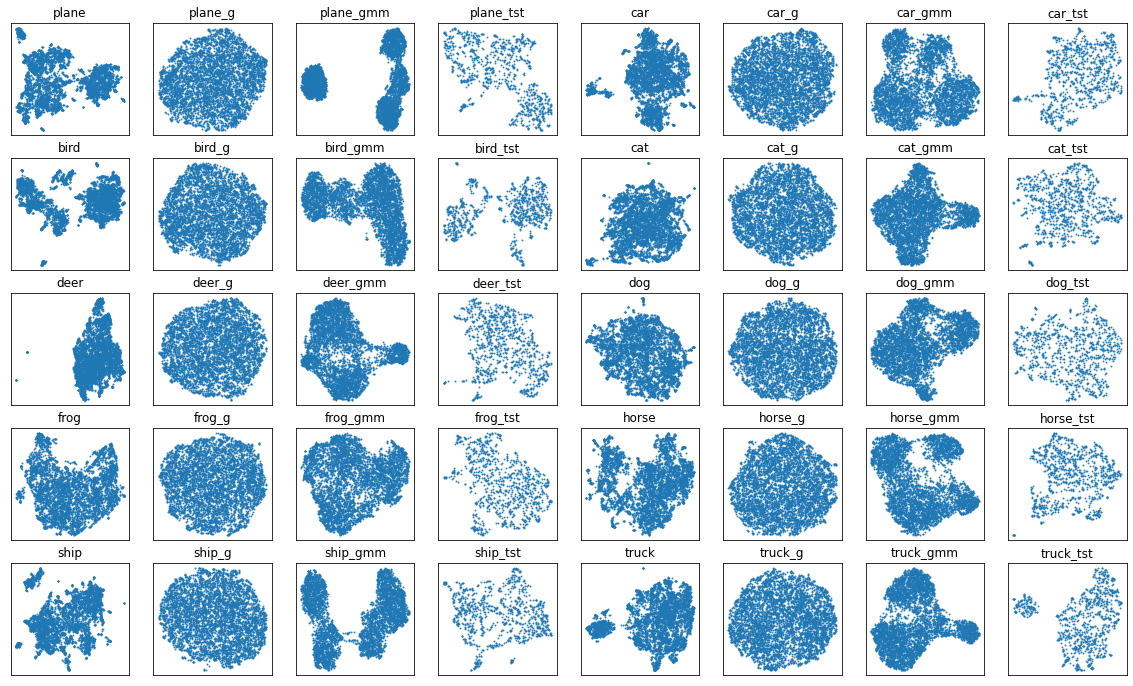

In [7]:
plt.figure(figsize=(20, 12))

idx = 1
for c in range(10):
    for e, suffix in [
        (embeddings, ""),
        (embeddings_g, "_g"),
        (embeddings_gmm, "_gmm"),
        (embeddings_tst, "_tst"),
    ]:
        plt.subplot(5, 8, idx)
        plt.scatter(
            e[c][:, 0],
            e[c][:, 1],
            alpha=0.8,
            s=1
        )
        plt.title(CIFAR_CLS_NAMES[c] + suffix)
        plt.xticks([])
        plt.yticks([])

        idx += 1

### UMAP embedding deep dive

In [8]:
min_dist = 0.1
n_neighbors = 10
red = umap.UMAP(
    n_components=2,
    min_dist=min_dist,
    n_neighbors=n_neighbors,
    random_state=0,
)

xs_test_2d = red.fit_transform(DS.xs_test)
xs_test_2d_g = red.transform(DS_G.xs_test)
xs_test_2d_gmm = red.transform(DS_GMM.xs_test)

In [9]:
# Visualize xs_test_2d in plotly
df = pd.DataFrame(
    {
        "x": xs_test_2d_gmm[:, 0],
        "y": xs_test_2d_gmm[:, 1],
        "class": DS.ys_test,
        "class_name": [CIFAR_CLS_NAMES[c] for c in DS.ys_test],
    }
)

fig = px.scatter(
    df.sort_values("class"),
    x="x",
    y="y",
    color="class_name",
    title=f"UMAP of CIFAR-10 test set ({min_dist=}, {n_neighbors=})",
    labels={"class_name": "Class"},
    width=800,
    height=500,
)

# Make alpha 0.5
fig.update_traces(marker=dict(opacity=0.8))

fig.show()

# Visualize embeddings (slow)

In [6]:
def plot_embeddings(xs: np.ndarray, ys: np.ndarray, **plt_kwargs):
    for c in range(10):
        mask = ys == c
        plt.scatter(
            xs[mask, 0],
            xs[mask, 1],
            label=CIFAR_CLS_NAMES[c],
            **plt_kwargs,
        )

    # Show legend with larger and alpha=1 markers
    # Put the legend on the outside top-right of the plot
    leg = plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    for lh in leg.legendHandles:  # type: ignore
        lh.set_alpha(1)
        lh.set_sizes([69])

### UMAP

In [7]:
UMAP_SEED = 1

In [8]:
# Compute UMAP embeddings
red = umap.UMAP(random_state=UMAP_SEED)
x_2d: np.ndarray = red.fit_transform(DS.xs_train) # type: ignore

In [ ]:
# Compute UMAP embeddings on normalized data
# red_norm = umap.UMAP(random_state=UMAP_SEED)
# ss = StandardScaler()
# xs_train_norm = ss.fit_transform(DS.xs_train)
# x_2d_norm: np.ndarray = red_norm.fit_transform(xs_train_norm) # type: ignore

In [10]:
# Compute UMAP embeddings of test data as well
x_2d_test: np.ndarray = red.transform(DS.xs_test) # type: ignore
# x_2d_test_norm: np.ndarray = red_norm.transform(ss.transform(DS.xs_test)) # type: ignore

In [11]:
# Compute UMAP embeddings of gaussian test data
x_2d_test_g: np.ndarray = red.transform(DS_G.xs_test) # type: ignore
# x_2d_test_g_norm: np.ndarray = red_norm.transform(ss.transform(DS_G.xs_test)) # type: ignore

In [12]:
# Compute UMAP embeddings of gaussian test data
x_2d_test_gmm: np.ndarray = red.transform(DS_GMM.xs_test) # type: ignore
# x_2d_test_gmm_norm: np.ndarray = red_norm.transform(ss.transform(DS_GMM.xs_test)) # type: ignore

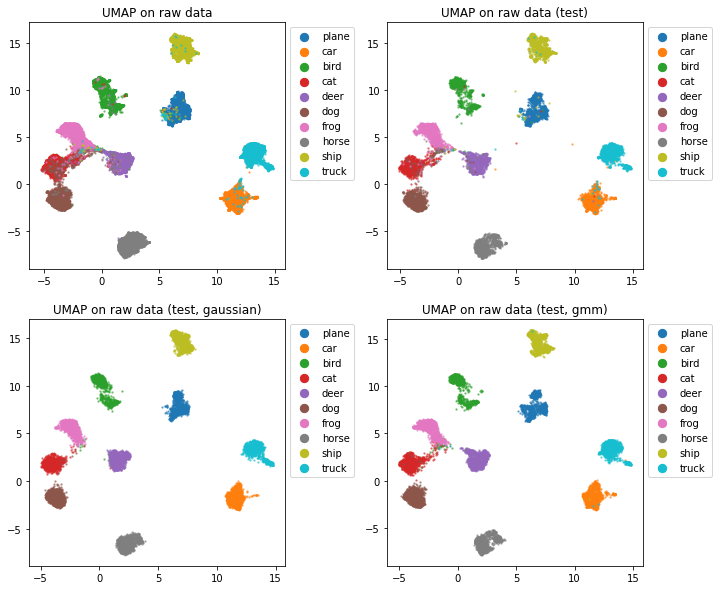

In [16]:
plt.figure(figsize=(11, 10))
# Increase space between plots
plt.subplots_adjust(wspace=0.4)

s = 2
alpha = 0.5

plt.subplot(2, 2, 1)
plot_embeddings(x_2d, DS.ys_train, s=s, alpha=alpha)
plt.title("UMAP on raw data")

plt.subplot(2, 2, 2)
plot_embeddings(x_2d_test, DS.ys_test, s=s, alpha=alpha)
plt.title("UMAP on raw data (test)")

plt.subplot(2, 2, 3)
plot_embeddings(x_2d_test_g, DS_G.ys_test, s=s, alpha=alpha)
plt.title("UMAP on raw data (test, gaussian)")

plt.subplot(2, 2, 4)
plot_embeddings(x_2d_test_gmm, DS_GMM.ys_test, s=s, alpha=alpha)
plt.title("UMAP on raw data (test, gmm)");

# plt.subplot(2, 3, 4)
# plot_embeddings(x_2d_norm, DS.ys_train, s=s, alpha=alpha)
# plt.title("UMAP on normalized data")

# plt.subplot(2, 3, 5)
# plot_embeddings(x_2d_test_norm, DS.ys_test, s=s, alpha=alpha)
# plt.title("UMAP on normalized data (test)")

# plt.subplot(2, 3, 6)
# plot_embeddings(x_2d_test_g_norm, DS_G.ys_test, s=s, alpha=alpha)
# plt.title("UMAP on normalized data (test, gaussian)");